## Step 1: Data Exploration &  Data Cleaning

In [1]:
from pyspark import SparkConf, SparkContext
conf = SparkConf()
conf.setAppName("project")
conf.setMaster("local[*]")
sc = SparkContext(conf=conf)

In [2]:
import matplotlib.pyplot as plt 
import numpy as np

In [3]:
rdd_data = sc.textFile("spam_utf.csv")
rdd_tuple = rdd_data.map(lambda x: x.split(','))
rdd_tuple.take(2)

[['v1', 'v2', '', '', ''],
 ['ham',
  '"Go until jurong point',
  ' crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."',
  '',
  '',
  '']]

In [4]:
#replacing comma separator with semicolon
import csv
text=[]
with open("spam_utf.csv", mode="r") as infile:
    reader = csv.reader(infile, delimiter=',')
    with open("spam_utf_semicolon.txt", mode="w") as outfile:
        for row in reader:
            writer = csv.writer(outfile, delimiter='<')
            text.append(row)
        writer.writerows(text)

In [5]:
#creating rdd_tuple by splitting by semicolon
rdd_data = sc.textFile("spam_utf_semicolon.txt")
rdd_tuple = rdd_data.map(lambda x: x.split('<'))
rdd_tuple.take(2)

[['v1', 'v2', '', '', ''],
 ['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
  '',
  '',
  '']]

In [6]:
#removing 2-3-4 columns
rdd_tuple = rdd_tuple.map(lambda row: row[0:2])
rdd_tuple.take(10)

[['v1', 'v2'],
 ['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
 ['ham', 'Ok lar... Joking wif u oni...'],
 ['spam',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
 ['ham', 'U dun say so early hor... U c already then say...'],
 ['ham', "Nah I don't think he goes to usf, he lives around here though"],
 ['spam',
  "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv"],
 ['ham',
  'Even my brother is not like to speak with me. They treat me like aids patent.'],
 ['ham',
  "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune"],
 ['spam',
  'WINNER!! As a valued network customer you have been select

In [7]:
#how many sms are there?
rdd_tuple.count()

5575

In [8]:
#grouping by class
list_target = rdd_tuple.map(lambda x: (x[0], 1)) \
                        .reduceByKey(lambda x,y: x+y) \
                        .takeOrdered(10, (lambda x: x[1])) 
list_target

[('v1', 1), ('ham"""', 2), ('spam', 747), ('ham', 4825)]

In [10]:
#removing header from rdd
header = rdd_tuple.take(1)
rdd_tuple = rdd_tuple.filter(lambda line : line not in header)
rdd_tuple.take(5)

[['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
 ['ham', 'Ok lar... Joking wif u oni...'],
 ['spam',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
 ['ham', 'U dun say so early hor... U c already then say...'],
 ['ham', "Nah I don't think he goes to usf, he lives around here though"]]

In [14]:
#replacing ham""" with ham
def replace(row):
    if row[0]=='ham"""':
        row[0]='ham'
    return row


lista = rdd_tuple.map(lambda x: replace(x),1)\
                    .map(lambda x: (x[0], 1)) \
                    .reduceByKey(lambda x,y: x+y) 
lista.collect()

[('ham', 4827), ('spam', 747)]

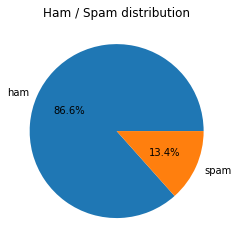

In [15]:
target, count_target = zip(*lista.collect())
#plt.figure(figsize=(15,5))
plt.pie(count_target, labels=target, autopct='%1.1f%%')
plt.title('Ham / Spam distribution')
plt.show()

In [16]:
# most common words in spam sms
common_word_spam = rdd_tuple.filter(lambda x: x[0] == "spam")\
                            .flatMap(lambda x: [(w,1) for w in x[1].split(' ')]) \
                            .reduceByKey(lambda x,y: x+y)\
                            .takeOrdered(50, (lambda x: -x[1]))
common_word_spam

[('to', 601),
 ('a', 358),
 ('or', 185),
 ('call', 183),
 ('your', 183),
 ('the', 177),
 ('2', 169),
 ('for', 168),
 ('you', 164),
 ('is', 140),
 ('Call', 134),
 ('on', 133),
 ('have', 125),
 ('and', 117),
 ('from', 111),
 ('ur', 107),
 ('with', 101),
 ('&', 98),
 ('of', 93),
 ('4', 92),
 ('FREE', 88),
 ('mobile', 81),
 ('are', 77),
 ('our', 75),
 ('claim', 73),
 ('To', 73),
 ('You', 72),
 ('U', 70),
 ('Your', 69),
 ('txt', 68),
 ('text', 68),
 ('in', 64),
 ('now', 64),
 ('Txt', 63),
 ('reply', 58),
 ('free', 56),
 ('contact', 56),
 ('-', 53),
 ('be', 48),
 ('now!', 48),
 ('u', 47),
 ('just', 46),
 ('send', 45),
 ('Nokia', 45),
 ('won', 45),
 ('get', 45),
 ('only', 44),
 ('this', 44),
 ('per', 44),
 ('prize', 43)]

In [17]:
common_word_spam2 = rdd_tuple.filter(lambda x: x[0] == "spam")\
                            .flatMap(lambda x: [(w,1) for w in x[1].split(' ')]) \
                            .reduceByKey(lambda x,y: x+y)

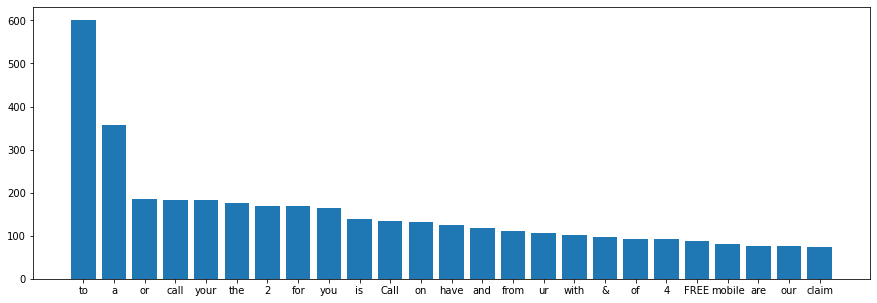

In [18]:
word, count_word = zip(*common_word_spam2.takeOrdered(25, (lambda x: -x[1])))
plt.figure(figsize=(15,5))
plt.bar(
    x=word, height=count_word
)
plt.show()

In [19]:
# most common words in non-spam ham sms
common_word_spam = rdd_tuple.filter(lambda x: x[0] == "ham")\
                            .flatMap(lambda x: [(w,1) for w in x[1].split(' ')]) \
                            .reduceByKey(lambda x,y: x+y)\
                            .takeOrdered(10, (lambda x: -x[1]))
common_word_spam

[('to', 1530),
 ('you', 1458),
 ('I', 1435),
 ('the', 1019),
 ('a', 969),
 ('and', 738),
 ('i', 736),
 ('in', 734),
 ('u', 645),
 ('is', 638)]

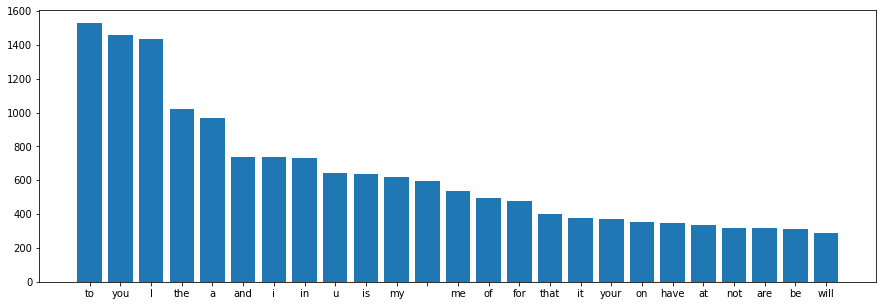

In [20]:
common_word_ham2 = rdd_tuple.filter(lambda x: x[0] == "ham")\
                            .flatMap(lambda x: [(w,1) for w in x[1].split(' ')]) \
                            .reduceByKey(lambda x,y: x+y)
word, count_word = zip(*common_word_ham2.takeOrdered(25, (lambda x: -x[1])))
plt.figure(figsize=(15,5))
plt.bar(
    x=word, height=count_word
)
plt.show()

In [18]:
# most common correlated words in spam sms
def line_to_bigram(line):
    words = line.lower().split(" ") #lower case text
    return [(words[i-1], words[i]) for i in range(1, len(words))]


common_word_spam = rdd_tuple.filter(lambda x: x[0] == "spam")\
                            .flatMap(lambda x: line_to_bigram(x[1]))\
                            .map(lambda x: (x, 1)) \
                            .reduceByKey(lambda x,y: x+y) \
                            .takeOrdered(10, (lambda x: -x[1])) 

common_word_spam

[(('you', 'have'), 69),
 (('have', 'won'), 52),
 (('your', 'mobile'), 46),
 (('please', 'call'), 42),
 (('won', 'a'), 40),
 (('to', 'claim'), 39),
 (('this', 'is'), 38),
 (('to', 'contact'), 37),
 (('you', 'are'), 35),
 (('cash', 'or'), 27)]

In [19]:
# most common correlated words in ham sms
def line_to_bigram(line):
    words = line.lower().split(" ")
    return [(words[i-1], words[i]) for i in range(1, len(words))]


common_word_spam = rdd_tuple.filter(lambda x: x[0] == "ham")\
                            .flatMap(lambda x: line_to_bigram(x[1]))\
                            .map(lambda x: (x, 1)) \
                            .reduceByKey(lambda x,y: x+y) \
                            .takeOrdered(10, (lambda x: -x[1])) 

common_word_spam

[(('', '&lt;#&gt;'), 221),
 (('are', 'you'), 149),
 (('&lt;#&gt;', ''), 132),
 (('i', 'am'), 127),
 (('have', 'a'), 108),
 (('i', 'will'), 97),
 (('do', 'you'), 89),
 (('you', 'are'), 88),
 (('in', 'the'), 86),
 (('i', 'have'), 82)]

In [20]:
# understanding special character ""&lt;#&gt"
# how many sms with special char?
common_word_spam = rdd_tuple.filter(lambda x: x[0] == "ham")\
                            .flatMap(lambda x: [(w,1) for w in x[1].split(' ')]) \
                            .filter(lambda x: x[0] == "&lt;#&gt;")\
                            .reduceByKey(lambda x,y: x+y) 
common_word_spam.collect()

[('&lt;#&gt;', 276)]

In [21]:
rdd_tuple.take(1)

[['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']]

## Data Enginering & Data Understanding

#### Imports

In [22]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/hpsa10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Functions

In [23]:
def CountPunct(line):
    letters = [chr(x) for x in range(65,91)]
    numbers = [chr(x) for x in range(48,58)]
    count=0
    for letter in line:
        if letter.upper() not in letters and letter.upper() not in numbers and letter.upper() != ' ':
            count+=1
    return count

line='I+++[sono]cccc     .'
print(CountPunct(line))

6


In [24]:
def CountQuestionMarks(line):
    count=0
    for char in line:
        if char == '?':
            count+=1
    return count

line='0955587/ aaacks  a?'
print(CountQuestionMarks(line))

1


In [25]:
def CountExclMarks(line):
    count=0
    for char in line:
        if char == '!':
            count+=1
    return count

line='WINN!!!!!   !???'
print(CountExclMarks(line))

6


In [26]:
def CountCaps(line):
    Caps = [chr(x) for x in range(65,91)]
    count=0
    words = line.split()
    for word in words:
        if len(word)<=1:
            for letter in word:
                if letter in Caps:
                    count+=1
        else:
            if word[1] in Caps:
                for letter in word:
                    if letter in Caps:
                        count+=1
    return count

line='Io SONO A SPARTA'
CountCaps(line)

11

In [27]:
def CountCapsWords(line):
    Caps = [chr(x) for x in range(65,91)]
    count=0
    words = line.split()
    for word in words:
        if len(word)<=1:
            continue
        caps_count=0
        for letter in word:
            if letter in Caps:
                caps_count+=1
        if caps_count>=2:
            count+=1
    return count

line='Io Sono a Sparta!!!!!!!!!!!!!!!!!! A'
CountCapsWords(line)

0

In [28]:
def isLink(line):
    words = line.lower().split(" ") #lower case text
    count=0
    for letter in words:
        for i in range (len(letter)):
            if len(letter)> 2:
                if letter[i-2]=="w" and letter[i-1] =="w" and letter[i] =="w":
                    count=1
            if len(letter)> 3:
                if letter[i-3]=="h" and letter[i-2] =="t" and letter[i-1] =="t" and letter[i] =="p":
                    count=1
    return count

line='Io sono SPARTA www.ciao.it a'
isLink(line)

1

In [29]:
def CountNum(line):
    numbers = [chr(x) for x in range(48,58)]
    count=0
    for char in line:
        if char in numbers:
            count+=1
    return count

line='0955587/ aaacks  a'
print(CountNum(line))

7


In [30]:
STOPWORDS = set(stopwords.words('english'))
more_stops = {'ur','n','u','r'}
STOPWORDS = STOPWORDS.union(more_stops)

def BagOfWords(line, stopwords):
    pattern = re.compile("[^a-z0-9 ]+")
    x = pattern.sub(' ', line.lower())
    return [w for w in x.split() if w not in stopwords]

line = 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
print(BagOfWords(line, STOPWORDS))

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']


#### Applying functions to RDD

In [31]:
Header = ['ham/spam','text','len_ch','punct_count','question_count','excl_count','caps_count_ch','caps_count_words','contains_link','num_count','bag_of_words']

In [32]:
rdd_all = rdd_tuple.map(lambda y: (y[0],len(y[1]),\
                                 CountPunct(y[1]),\
                                 CountQuestionMarks(y[1]),\
                                 CountExclMarks(y[1]),\
                                 CountCaps(y[1]),\
                                 CountCapsWords(y[1]),\
                                 isLink(y[1]),\
                                 CountNum(y[1]),\
                                 BagOfWords(y[1], STOPWORDS)))

In [33]:
rdd_all.take(1)

[('ham',
  111,
  9,
  0,
  0,
  0,
  0,
  0,
  0,
  ['go',
   'jurong',
   'point',
   'crazy',
   'available',
   'bugis',
   'great',
   'world',
   'la',
   'e',
   'buffet',
   'cine',
   'got',
   'amore',
   'wat'])]

#### Length of messages

In [34]:
rdd_len_ham = rdd_all.filter(lambda x: x[0] == 'ham' and x[1]<200).map(lambda x: x[1])
rdd_len_spam = rdd_all.filter(lambda x: x[0] == 'spam' and x[1]<200).map(lambda x: x[1])
data_ham=rdd_len_ham.collect()
data_spam=rdd_len_spam.collect()

In [37]:
data_ham2 = rdd_all.filter(lambda x: x[0] == 'ham').map(lambda x: x[1]).collect()
data_spam2 = rdd_all.filter(lambda x: x[0] == 'spam').map(lambda x: x[1]).collect()

Text(0.5, 1.0, 'Lenght of ham messages box plot')

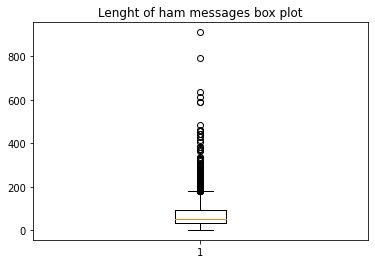

In [38]:
plt.boxplot(data_ham2)
plt.title('Lenght of ham messages box plot')

Text(0.5, 1.0, 'Lenght of spam messages box plot')

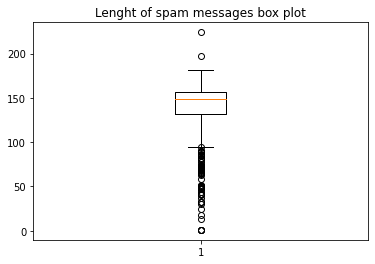

In [39]:
plt.boxplot(data_spam2)
plt.title('Lenght of spam messages box plot')

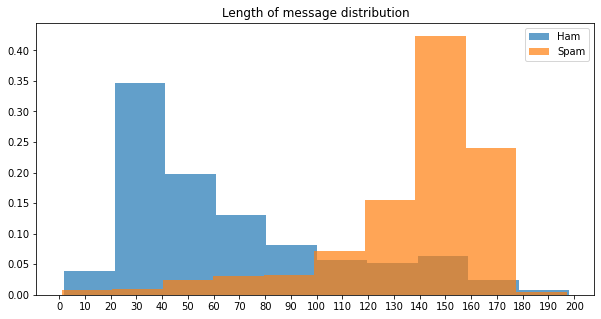

In [40]:
x = [x for x in range(0,210,10)]
plt.figure(figsize=(10,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.7, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.7, bins=10, label='Spam')
plt.xticks(x)
plt.title('Length of message distribution')
plt.legend()

#### Punctuation Distribution

In [41]:
rdd_punct_ham = rdd_all.filter(lambda x: x[0] == 'ham' and x[2]<20).map(lambda x: x[2])
rdd_punct_spam = rdd_all.filter(lambda x: x[0] == 'spam' and x[2]<20).map(lambda x: x[2])
data_ham=rdd_punct_ham.collect()
data_spam=rdd_punct_spam.collect()

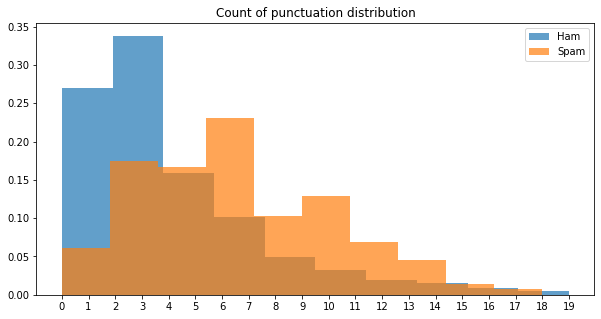

In [42]:
x = [x for x in range(0,20,1)]
plt.figure(figsize=(10,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.7, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.7, bins=10, label='Spam')
plt.xticks(x)
plt.title('Count of punctuation distribution')
plt.legend()

#### Question Mark  Distribution

In [43]:
rdd_q_ham = rdd_all.filter(lambda x: x[0] == 'ham' and x[3]<6).map(lambda x: x[3])
rdd_q_spam = rdd_all.filter(lambda x: x[0] == 'spam' and x[3]<6).map(lambda x: x[3])
data_ham=rdd_q_ham.collect()
data_spam=rdd_q_spam.collect()

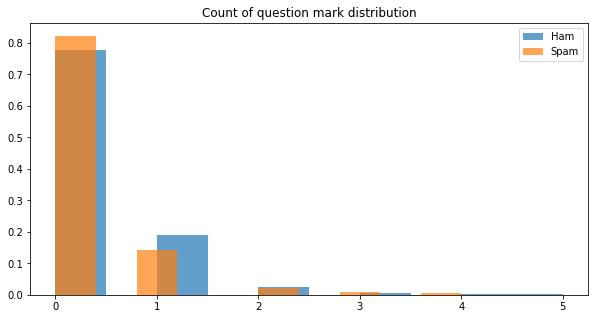

In [44]:
plt.figure(figsize=(10,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.7, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.7, bins=10, label='Spam')
#plt.xticks(x)
plt.title('Count of question mark distribution')
plt.legend()

#### Exclamation marks distribution

In [45]:
rdd_exc_ham = rdd_all.filter(lambda x: x[0] == 'ham' and x[4]<6).map(lambda x: x[4])
rdd_exc_spam = rdd_all.filter(lambda x: x[0] == 'spam' and x[4]<6).map(lambda x: x[4])
data_ham=rdd_exc_ham.collect()
data_spam=rdd_exc_spam.collect()

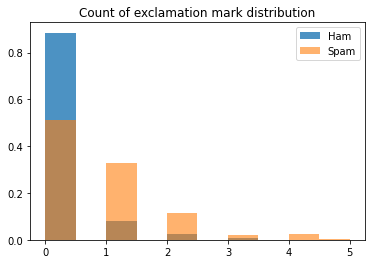

In [46]:
#plt.figure(figsize=(10,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.8, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.6, bins=10, label='Spam')
#plt.xticks(x)
plt.title('Count of exclamation mark distribution')
plt.legend()

#### Caps count distribution

In [47]:
rdd_caps_ham = rdd_all.filter(lambda x: x[0] == 'ham' and x[5]<30).map(lambda x: x[5])
rdd_caps_spam = rdd_all.filter(lambda x: x[0] == 'spam' and x[5]<30).map(lambda x: x[5])
data_ham=rdd_caps_ham.collect()
data_spam=rdd_caps_spam.collect()

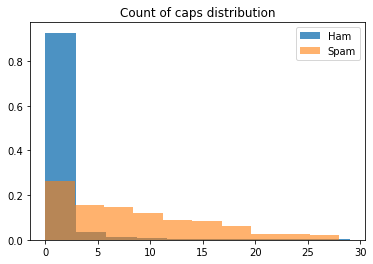

In [48]:
#plt.figure(figsize=(10,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.8, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.6, bins=10, label='Spam')
#plt.xticks(x)
plt.title('Count of caps distribution')
plt.legend()

#### Caps word count distribution

In [49]:
rdd_wcaps_ham = rdd_all.filter(lambda x: x[0] == 'ham' and x[5]<15).map(lambda x: x[6])
rdd_wcaps_spam = rdd_all.filter(lambda x: x[0] == 'spam' and x[5]<15).map(lambda x: x[6])
data_ham=rdd_wcaps_ham.collect()
data_spam=rdd_wcaps_spam.collect()

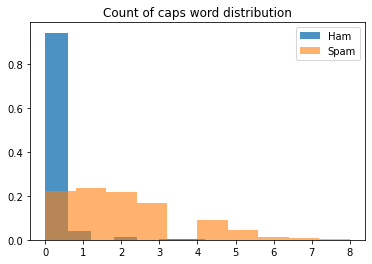

In [50]:
#plt.figure(figsize=(10,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.8, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.6, bins=10, label='Spam')
#plt.xticks(x)
plt.title('Count of caps word distribution')
plt.legend()

#### Link dummmy varaible

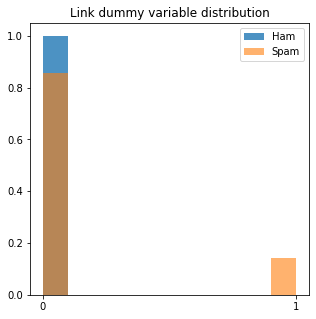

In [51]:
rdd_link_ham = rdd_all.filter(lambda x: x[0] == 'ham').map(lambda x: x[7])
rdd_link_spam = rdd_all.filter(lambda x: x[0] == 'spam').map(lambda x: x[7])
data_ham=rdd_link_ham.collect()
data_spam=rdd_link_spam.collect()

x =[0,1]
plt.figure(figsize=(5,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.8, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.6, bins=10, label='Spam')
plt.xticks(x)
plt.title('Link dummy variable distribution')
plt.legend()

#### Count of numbers distribution

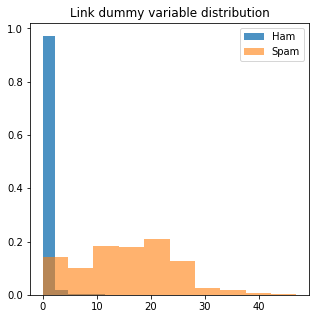

In [52]:
rdd_num_ham = rdd_all.filter(lambda x: x[0] == 'ham').map(lambda x: x[8])
rdd_num_spam = rdd_all.filter(lambda x: x[0] == 'spam').map(lambda x: x[8])
data_ham=rdd_num_ham.collect()
data_spam=rdd_num_spam.collect()

plt.figure(figsize=(5,5))
plt.hist(data_ham, weights=np.ones(len(data_ham)) / len(data_ham), alpha=0.8, bins=10, label='Ham')
plt.hist(data_spam, weights=np.ones(len(data_spam)) / len(data_spam), alpha=0.6, bins=10, label='Spam')
#plt.xticks(x)
plt.title('Link dummy variable distribution')
plt.legend()

## Data Pre-processing

### With HashingTF

In [53]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.feature import HashingTF, StandardScaler
from pyspark.mllib.feature import LabeledPoint
from pyspark.mllib.linalg import Vectors

In [54]:
tf_transformer = HashingTF(numFeatures=32768)

In [55]:
Vectors.sparse

<function pyspark.mllib.linalg.Vectors.sparse(size, *args)>

In [56]:
rdd_new = rdd_all.map(lambda x: (0.0 if x[0] == 'ham' else 1.0,[float(x[1]),float(x[2]),float(x[3]),float(x[4]),float(x[5]),\
                                 float(x[6]),float(x[7]),float(x[8])]+Vectors.dense(tf_transformer.transform(x[9])).tolist()))

In [57]:
a=rdd_new.take(1)[0][1] #type list

def SparseInput(lis):
    indexlist = []
    valuelist = []
    for i in range(len(lis)):
        if lis[i] != 0:
            indexlist.append(i)
            valuelist.append(lis[i])
    return len(lis), indexlist, valuelist
    
b, c, e = SparseInput(a)
print(b,c,e)
Vectors.sparse(b, c, e)

32776 [0, 1, 164, 1505, 4556, 5004, 9762, 12353, 12406, 15689, 17849, 18117, 21089, 24995, 28554, 29822, 31008] [111.0, 9.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


SparseVector(32776, {0: 111.0, 1: 9.0, 164: 1.0, 1505: 1.0, 4556: 1.0, 5004: 1.0, 9762: 1.0, 12353: 1.0, 12406: 1.0, 15689: 1.0, 17849: 1.0, 18117: 1.0, 21089: 1.0, 24995: 1.0, 28554: 1.0, 29822: 1.0, 31008: 1.0})

In [58]:
rdd_sparse = rdd_new.map(lambda x: (x[0], Vectors.sparse(SparseInput(x[1])[0],SparseInput(x[1])[1],SparseInput(x[1])[2])))
rdd_sparse.take(1)

[(0.0,
  SparseVector(32776, {0: 111.0, 1: 9.0, 164: 1.0, 1505: 1.0, 4556: 1.0, 5004: 1.0, 9762: 1.0, 12353: 1.0, 12406: 1.0, 15689: 1.0, 17849: 1.0, 18117: 1.0, 21089: 1.0, 24995: 1.0, 28554: 1.0, 29822: 1.0, 31008: 1.0}))]

In [56]:
label_sparse = rdd_sparse.map(lambda x : LabeledPoint(x[0], x[1]))
label_sparse.take(1)

[LabeledPoint(0.0, (32776,[0,1,164,1505,4556,5004,9762,12353,12406,15689,17849,18117,21089,24995,28554,29822,31008],[111.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]

#### Dense Labeled Point

In [57]:
# rdd_dense = rdd_all.map(lambda x: (0.0 if x[0] == 'ham' else 1.0,Vectors.dense([float(x[1]),float(x[2]),float(x[3]),float(x[4]),float(x[5]),\
#                                  float(x[6]),float(x[7]),float(x[8])]+Vectors.dense(tf_transformer.transform(x[9])).tolist())))
# label_dense = rdd_dense.map(lambda x : LabeledPoint(x[0], x[1]))
# label_dense.take(1)

### Without HashingTF

In [58]:
rdd_funct = rdd_all.map(lambda x: (0.0 if x[0] == 'ham' else 1.0,float(x[1]),float(x[2]),float(x[3]),float(x[4]),float(x[5]),\
                                 float(x[6]),float(x[7]),float(x[8])))
rdd_funct.take(1)

[(0.0, 111.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)]

In [59]:
label_point = rdd_funct.map(lambda x : LabeledPoint(x[0], x[1:]))
label_point.take(1)

[LabeledPoint(0.0, [111.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0])]

### Split into train and Test sets

In [60]:
train_label_sparse, test_label_sparse = label_sparse.randomSplit([0.8,0.2], seed=1)
train_label_point, test_label_point = label_point.randomSplit([0.8,0.2], seed=1)

In [61]:
# labels_NoTF= train_label_point.map(lambda x : x.label)
# features_NoTF= train_label_point.map(lambda x : x.features)
# features_NoTF.take(3)

## Modeling

#### Imports

In [62]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sn
import pandas as pd
import sklearn.metrics

#### Functions

In [63]:
# auxiliar function
def confusion_matrix(labels, predictions):
    counts_rdd = predictions.zip(labels).map(lambda k: (k,1)).reduceByKey(lambda l,r: l+r)
    counts = dict(((i,j),0) for i in [0,1] for j in [0,1])  # set to 0 all the entries
    counts.update( dict(counts_rdd.collect()) )  # update the non-0 entries
    confusion_matrix = [
        [
            counts[(pred,act)]
            for act in [0,1]
        ] for pred in [0,1]
    ]
    df_cm = pd.DataFrame(confusion_matrix, index = ["Pred 0", "Pred 1"], columns = ["Act 0", "Act 1"])
    sn.heatmap(df_cm, annot=True, fmt='', annot_kws={"size": 14})

In [64]:
def ModelEvaluation(model, trainingData, testData, showTrees=False, showMatrix=False):
    
    train_labels= trainingData.map(lambda x : x.label)
    train_features= trainingData.map(lambda x : x.features)
    test_labels= testData.map(lambda x : x.label)
    test_features= testData.map(lambda x : x.features)
    
    predictions_train = model.predict(trainingData.map(lambda x: x.features))
    labelsAndPredictions_train = trainingData.map(lambda lp: lp.label).zip(predictions_train)
    testErr_train = labelsAndPredictions_train.filter(lambda lp: lp[0] != lp[1]).count() / float(trainingData.count())

    predictions = model.predict(testData.map(lambda x: x.features))
    labelsAndPredictions = testData.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(testData.count())
    
    print('Train Error = ' + str(testErr_train))
    print('Test Error = ' + str(testErr))    
    print()
    print('Train set:')
    print("Accuracy:", round(sklearn.metrics.accuracy_score(train_labels.collect(),predictions_train.collect()),4))
    print("Precision:", round(sklearn.metrics.precision_score(train_labels.collect(),predictions_train.collect()),4))
    print("Recall:", round(sklearn.metrics.recall_score(train_labels.collect(),predictions_train.collect()),4))
    print()
    print('Test set:')
    print("Accuracy:", round(sklearn.metrics.accuracy_score(test_labels.collect(),predictions.collect()),4))
    print("Precision:", round(sklearn.metrics.precision_score(test_labels.collect(),predictions.collect()),4))
    print("Recall:", round(sklearn.metrics.recall_score(test_labels.collect(),predictions.collect()),4))
    
    if showMatrix:
        confusion_matrix(test_labels, predictions)
    
    if showTrees:
        print()
        print('Learned classification forest model:')
        print(model.toDebugString())

#### Without HashingTF

In [45]:
trainingData = train_label_point
testData = test_label_point

#### ------------ Random Forest

In [46]:
rf = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
numTrees=10, featureSubsetStrategy="auto",
impurity='gini', maxDepth=6, maxBins=100, seed=0)

Train Error = 0.01409080742563185
Test Error = 0.019038984587488667

Train set:
Accuracy: 0.9859
Precision: 0.9736
Recall: 0.9201

Test set:
Accuracy: 0.981
Precision: 0.9774
Recall: 0.8784


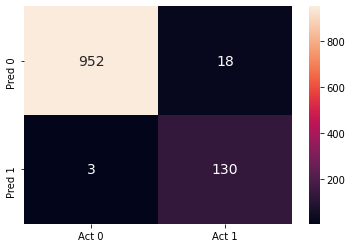

In [47]:
ModelEvaluation(rf, trainingData, testData, showMatrix=True)

In [48]:
print(Header)

['ham/spam', 'text', 'len_ch', 'punct_count', 'question_count', 'excl_count', 'caps_count_ch', 'caps_count_words', 'contains_link', 'num_count', 'bag_of_words']


#### ------------ Decision Tree

In [49]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils

In [50]:
# Train a DecisionTree model.

dt = DecisionTree.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
impurity='gini', maxDepth=5, maxBins=32)

Train Error = 0.01409080742563185
Test Error = 0.019945602901178604

Train set:
Accuracy: 0.9859
Precision: 0.9786
Recall: 0.9151

Test set:
Accuracy: 0.9801
Precision: 0.9846
Recall: 0.8649

Learned classification forest model:
DecisionTreeModel classifier of depth 5 with 37 nodes
  If (feature 7 <= 4.5)
   If (feature 6 <= 0.5)
    If (feature 5 <= 1.5)
     Predict: 0.0
    Else (feature 5 > 1.5)
     If (feature 7 <= 1.5)
      Predict: 0.0
     Else (feature 7 > 1.5)
      If (feature 4 <= 17.5)
       Predict: 1.0
      Else (feature 4 > 17.5)
       Predict: 0.0
   Else (feature 6 > 0.5)
    If (feature 4 <= 0.5)
     If (feature 1 <= 9.5)
      If (feature 3 <= 1.5)
       Predict: 1.0
      Else (feature 3 > 1.5)
       Predict: 0.0
     Else (feature 1 > 9.5)
      Predict: 0.0
    Else (feature 4 > 0.5)
     Predict: 1.0
  Else (feature 7 > 4.5)
   If (feature 7 <= 9.5)
    If (feature 4 <= 0.5)
     If (feature 0 <= 20.5)
      Predict: 1.0
     Else (feature 0 > 20.5)
    

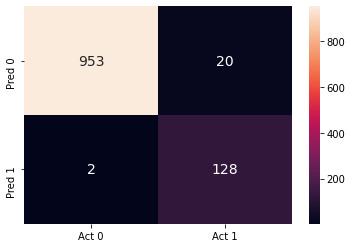

In [215]:
ModelEvaluation(dt, trainingData, testData, showMatrix=True, showTrees=True)

#### ------------ Logistic Regression

In [53]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

In [54]:
lr = LogisticRegressionWithLBFGS.train(trainingData)

Train Error = 0.03086557817043167
Test Error = 0.038077969174977334

Train set:
Accuracy: 0.9691
Precision: 0.9112
Recall: 0.8536

Test set:
Accuracy: 0.9619
Precision: 0.8786
Recall: 0.8311


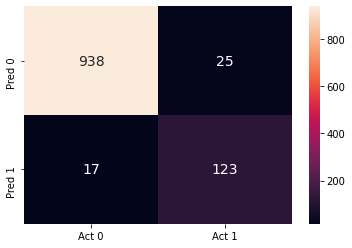

In [55]:
ModelEvaluation(lr, trainingData, testData, showMatrix=True)

#### ------------ Gradient Boost Classifier

In [73]:
from pyspark.mllib.tree import GradientBoostedTrees

In [57]:
gbc = GradientBoostedTrees.trainClassifier(trainingData, categoricalFeaturesInfo={}, numIterations=10)

Train Error = 0.01945873406396779
Test Error = 0.027198549410698096

Train set:
Accuracy: 0.9805
Precision: 0.9795
Recall: 0.8735

Test set:
Accuracy: 0.9728
Precision: 0.9683
Recall: 0.8243


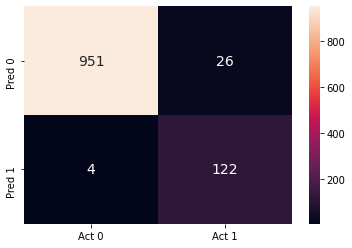

In [58]:
ModelEvaluation(gbc, trainingData, testData, showMatrix=True)

### Adding a new feature - Frequent words in ham and spam

In [65]:
train_rdd_all, test_rdd_all = rdd_all.randomSplit([0.8,0.2], seed=1)

In [66]:
numbers = [str(x) for x in range(100)]

word_ham = train_rdd_all.filter(lambda x: x[0] == "ham")\
                            .flatMap(lambda x: [(w,1) for w in x[9] if w not in numbers]) \
                            .reduceByKey(lambda x,y: x+y)\
                            .takeOrdered(25, (lambda x: -x[1]))
word_ham

[('gt', 274),
 ('lt', 272),
 ('get', 251),
 ('ok', 231),
 ('go', 206),
 ('call', 193),
 ('good', 193),
 ('know', 192),
 ('got', 186),
 ('like', 182),
 ('come', 179),
 ('day', 177),
 ('time', 160),
 ('love', 157),
 ('want', 139),
 ('one', 133),
 ('da', 131),
 ('lor', 130),
 ('home', 129),
 ('going', 127),
 ('need', 126),
 ('still', 124),
 ('sorry', 118),
 ('today', 115),
 ('k', 114)]

In [67]:
word_spam = train_rdd_all.filter(lambda x: x[0] == "spam")\
                            .flatMap(lambda x: [(w,1) for w in x[9] if w not in numbers]) \
                            .reduceByKey(lambda x,y: x+y)\
                            .takeOrdered(25, (lambda x: -x[1]))
word_spam

[('call', 290),
 ('free', 192),
 ('txt', 126),
 ('mobile', 108),
 ('stop', 95),
 ('claim', 93),
 ('text', 86),
 ('reply', 83),
 ('www', 81),
 ('prize', 74),
 ('get', 73),
 ('uk', 62),
 ('new', 61),
 ('send', 57),
 ('nokia', 56),
 ('cash', 55),
 ('week', 54),
 ('tone', 53),
 ('urgent', 52),
 ('150p', 49),
 ('co', 48),
 ('win', 46),
 ('c', 46),
 ('please', 45),
 ('contact', 45)]

In [68]:
spam_set = set([w[0] for w in word_spam])
ham_set = set([w[0] for w in word_ham])

def CountWords(bow, word_set):
    count=0
    for word in bow:
        if word in word_set:
            count+=1
    return float(count)

In [86]:
rdd_all.take(1)

[('ham',
  111,
  9,
  0,
  0,
  0,
  0,
  0,
  0,
  ['go',
   'jurong',
   'point',
   'crazy',
   'available',
   'bugis',
   'great',
   'world',
   'la',
   'e',
   'buffet',
   'cine',
   'got',
   'amore',
   'wat'])]

In [69]:
rdd_all_two = rdd_all.map(lambda x: (0.0 if x[0] == 'ham' else 1.0,float(x[1]),float(x[2]),float(x[3]),float(x[4]),float(x[5]),\
                                 float(x[6]),float(x[7]),float(x[8]),\
                                     CountWords(x[9],ham_set),CountWords(x[9],spam_set)))

rdd_all_two.take(10)

[(0.0, 111.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0),
 (0.0, 29.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0),
 (1.0, 155.0, 6.0, 0.0, 0.0, 4.0, 3.0, 0.0, 25.0, 0.0, 5.0),
 (0.0, 49.0, 6.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0),
 (0.0, 61.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 (1.0, 148.0, 10.0, 1.0, 2.0, 0.0, 2.0, 0.0, 4.0, 3.0, 2.0),
 (0.0, 77.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0),
 (0.0, 160.0, 6.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0),
 (1.0, 158.0, 8.0, 0.0, 3.0, 8.0, 2.0, 0.0, 19.0, 1.0, 4.0),
 (1.0, 154.0, 2.0, 1.0, 1.0, 6.0, 1.0, 0.0, 13.0, 1.0, 6.0)]

In [70]:
label_point_two = rdd_all_two.map(lambda x : LabeledPoint(x[0], x[1:]))
label_point_two.take(1)

[LabeledPoint(0.0, [111.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0])]

In [71]:
train_label_point_two, test_label_point_two = label_point_two.randomSplit([0.8,0.2], seed=1)

trainingData_two = train_label_point_two
testData_two = test_label_point_two

#### -----Random Forest (second attempt)

In [90]:
rf_two = RandomForest.trainClassifier(trainingData_two, numClasses=2, categoricalFeaturesInfo={},
numTrees=54, featureSubsetStrategy="auto",
impurity='gini', maxDepth=6, maxBins=100, seed=0)

Train Error = 0.009170208007157236
Test Error = 0.013599274705349048

Train set:
Accuracy: 0.9908
Precision: 1.0
Recall: 0.9318

Test set:
Accuracy: 0.9864
Precision: 0.9784
Recall: 0.9189


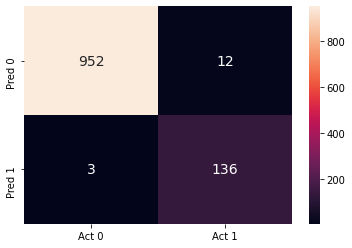

In [91]:
ModelEvaluation(rf_two, trainingData_two, testData_two, showMatrix=True)

#### -----Decision Tree (second attempt)

In [92]:
dt_two = DecisionTree.trainClassifier(trainingData_two, numClasses=2, categoricalFeaturesInfo={},
impurity='gini', maxDepth=5, maxBins=32)

Train Error = 0.012301498546186536
Test Error = 0.02085222121486854

Train set:
Accuracy: 0.9877
Precision: 0.9773
Recall: 0.9301

Test set:
Accuracy: 0.9791
Precision: 0.9562
Recall: 0.8851


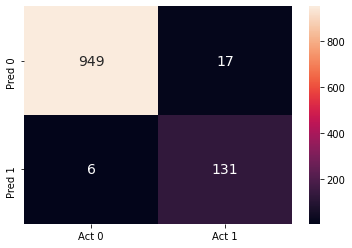

In [93]:
ModelEvaluation(dt_two, trainingData_two, testData_two, showMatrix=True, showTrees=False)

In [ ]:
Header_two = ['len_ch', 'punct_count', 'question_count', 'excl_count', 'caps_count_ch', 'caps_count_words', 'contains_link', 'num_count', 'count_ham','count_spam']

#### -----Logistic Regression (second attempt)

In [94]:
lr_two = LogisticRegressionWithLBFGS.train(trainingData_two)

Train Error = 0.026839633191679715
Test Error = 0.03535811423390753

Train set:
Accuracy: 0.9732
Precision: 0.9069
Recall: 0.8918

Test set:
Accuracy: 0.9646
Precision: 0.8609
Recall: 0.8784


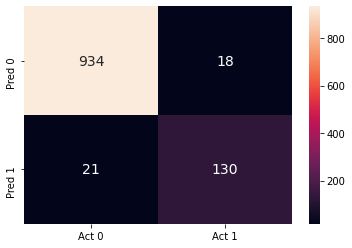

In [95]:
ModelEvaluation(lr_two, trainingData_two, testData_two, showMatrix=True, showTrees=False)

#### -----Gradient Boost Classifier (second attempt)

In [96]:
gbc_two = GradientBoostedTrees.trainClassifier(trainingData_two, categoricalFeaturesInfo={}, numIterations=54)

Train Error = 0.010512189666741221
Test Error = 0.012692656391659111

Train set:
Accuracy: 0.9895
Precision: 0.9894
Recall: 0.9318

Test set:
Accuracy: 0.9873
Precision: 0.9786
Recall: 0.9257


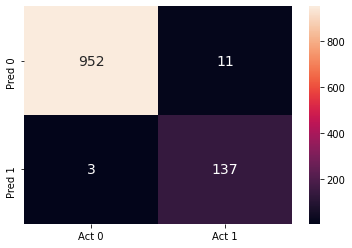

In [97]:
ModelEvaluation(gbc_two, trainingData_two, testData_two, showMatrix=True, showTrees=False)

## Optimization

#### ----- Gradeint Boost Classifier

In [98]:
num=[]
tr_err=[]
ts_err=[]


for n in range(2, 102, 2):
    
    print(n)
    gbc_n = GradientBoostedTrees.trainClassifier(trainingData_two, categoricalFeaturesInfo={}, numIterations=n)
    
    predictions_train = gbc_n.predict(trainingData_two.map(lambda x: x.features))
    labelsAndPredictions_train = trainingData_two.map(lambda lp: lp.label).zip(predictions_train)
    testErr_train = labelsAndPredictions_train.filter(lambda lp: lp[0] != lp[1]).count() / float(trainingData_two.count())

    predictions = gbc_n.predict(testData_two.map(lambda x: x.features))
    labelsAndPredictions = testData_two.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(testData_two.count())
    
    num.append(n)
    tr_err.append(testErr_train)
    ts_err.append(testErr)

    
print(num)
print(tr_err)
print(ts_err)

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
62
64
66
68
70
72
74
76
78
80
82
84
86
88
90
92
94
96
98
100
[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
[0.01722209796466115, 0.01722209796466115, 0.016998434354730484, 0.016998434354730484, 0.016551107134869156, 0.016327443524938492, 0.01610377991500783, 0.01610377991500783, 0.015209125475285171, 0.014538134645493177, 0.013419816595839858, 0.0125251621561172, 0.0125251621561172, 0.0125251621561172, 0.0125251621561172, 0.0125251621561172, 0.0125251621561172, 0.012301498546186536, 0.011406844106463879, 0.011630507716394543, 0.011406844106463879, 0.011183180496533215, 0.011183180496533215, 0.011183180496533215, 0.011183180496533215, 0.011183180496533215, 0.010512189666741221, 0.010512189666741221, 0.010288526056810557, 0.010288526056810557, 0.01051218

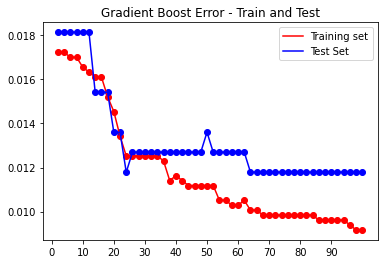

In [119]:
x = [x for x in range(0,100,10)]

plt.plot(num,tr_err, c='red', label='Training set')
plt.plot(num,ts_err, c='blue', label='Test Set')
plt.scatter(num,tr_err, c='red')
plt.scatter(num,ts_err, c='blue')
plt.xticks(x)
plt.title('Gradient Boost Error - Train and Test')
plt.legend()

In [74]:
gbc_three = GradientBoostedTrees.trainClassifier(trainingData_two, categoricalFeaturesInfo={}, numIterations=64)

Train Error = 0.010064862446879893
Test Error = 0.011786038077969175

Train set:
Accuracy: 0.9899
Precision: 0.9947
Recall: 0.9301

Test set:
Accuracy: 0.9882
Precision: 0.9856
Recall: 0.9257


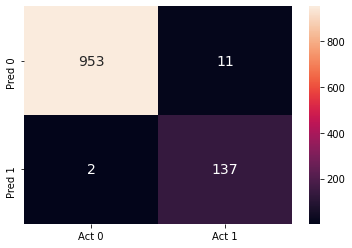

In [75]:
ModelEvaluation(gbc_three, trainingData_two, testData_two, showMatrix=True, showTrees=False)

#### ---- Random Forest

In [129]:
num=[]
tr_err=[]
ts_err=[]


for n in range(2, 102, 2):
    
    rf_n = RandomForest.trainClassifier(trainingData_two, numClasses=2, categoricalFeaturesInfo={},
    numTrees=n, featureSubsetStrategy="auto",
    impurity='gini', maxDepth=6, maxBins=100, seed=0)
    
    predictions_train = rf_n.predict(trainingData_two.map(lambda x: x.features))
    labelsAndPredictions_train = trainingData_two.map(lambda lp: lp.label).zip(predictions_train)
    testErr_train = labelsAndPredictions_train.filter(lambda lp: lp[0] != lp[1]).count() / float(trainingData_two.count())

    predictions = rf_n.predict(testData_two.map(lambda x: x.features))
    labelsAndPredictions = testData_two.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(testData_two.count())
    
    num.append(n)
    tr_err.append(testErr_train)
    ts_err.append(testErr)

NameError: name 'Done' is not defined

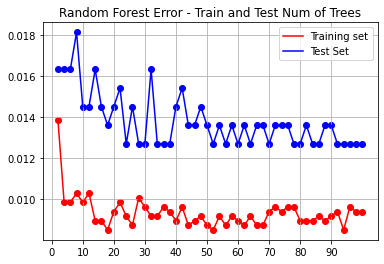

In [135]:
x = [x for x in range(0,100,10)]

plt.plot(num,tr_err, c='red', label='Training set')
plt.plot(num,ts_err, c='blue', label='Test Set')
plt.scatter(num,tr_err, c='red')
plt.scatter(num,ts_err, c='blue')
plt.xticks(x)
plt.title('Random Forest Error - Train and Test Num of Trees')
plt.legend()
plt.grid()

In [123]:
num_2=[]
tr_err_2=[]
ts_err_2=[]


for n in range(1, 11, 1):
    
    rf_n = RandomForest.trainClassifier(trainingData_two, numClasses=2, categoricalFeaturesInfo={},
    numTrees=92, featureSubsetStrategy="auto",
    impurity='gini', maxDepth=n, maxBins=100, seed=0)
    
    predictions_train = rf_n.predict(trainingData_two.map(lambda x: x.features))
    labelsAndPredictions_train = trainingData_two.map(lambda lp: lp.label).zip(predictions_train)
    testErr_train = labelsAndPredictions_train.filter(lambda lp: lp[0] != lp[1]).count() / float(trainingData_two.count())

    predictions = rf_n.predict(testData_two.map(lambda x: x.features))
    labelsAndPredictions = testData_two.map(lambda lp: lp.label).zip(predictions)
    testErr = labelsAndPredictions.filter(lambda lp: lp[0] != lp[1]).count() / float(testData_two.count())
    
    num_2.append(n)
    tr_err_2.append(testErr_train)
    ts_err_2.append(testErr)

1
2
3
4
5
6
7
8
9
10
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0.021024379333482442, 0.016998434354730484, 0.014761798255423843, 0.013419816595839858, 0.010512189666741221, 0.0093938716170879, 0.00782822634757325, 0.0073808991277119216, 0.006933571907850593, 0.006038917468127935]
[0.024478694469628286, 0.019038984587488667, 0.02085222121486854, 0.015412511332728921, 0.013599274705349048, 0.012692656391659111, 0.013599274705349048, 0.013599274705349048, 0.014505893019038985, 0.013599274705349048]


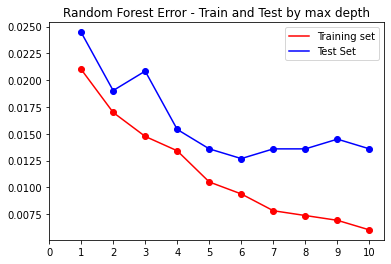

In [128]:
x = [x for x in range(0,11,1)]

plt.plot(num,tr_err, c='red', label='Training set')
plt.plot(num,ts_err, c='blue', label='Test Set')
plt.scatter(num,tr_err, c='red')
plt.scatter(num,ts_err, c='blue')
plt.xticks(x)
plt.title('Random Forest Error - Train and Test by max depth')
plt.legend()

In [78]:
rf_three = RandomForest.trainClassifier(trainingData_two, numClasses=2, categoricalFeaturesInfo={},
numTrees=92, featureSubsetStrategy="auto",
impurity='gini', maxDepth=6, maxBins=100, seed=0)

Train Error = 0.0093938716170879
Test Error = 0.012692656391659111

Train set:
Accuracy: 0.9906
Precision: 0.9982
Recall: 0.9318

Test set:
Accuracy: 0.9873
Precision: 0.9786
Recall: 0.9257


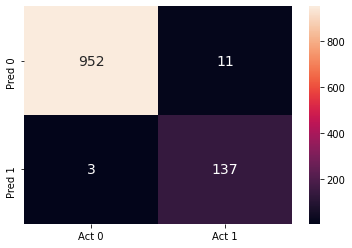

In [79]:
ModelEvaluation(rf_three, trainingData_two, testData_two, showMatrix=True, showTrees=False)